In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings

In [2]:
data_path = r"C:\Users\Admin\DataMining\data"
df = pd.read_csv(data_path)

print("Shape du dataset :", df.shape)
print("Colonnes :", df.columns.tolist())
print(df['class'].value_counts())

Shape du dataset : (203769, 168)
Colonnes : ['txId', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'fea

### Suppression des valeurs 'unknown'

In [3]:
df = df[df['class'] != 'unknown']
print("Shape après suppression des unknown :", df.shape)
print(df['class'].value_counts())

Shape après suppression des unknown : (46564, 168)
class
2    42019
1     4545
Name: count, dtype: int64


### Feature Reduction

####  1. Variance-Based Reduction

In [4]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
X = df[numeric_cols]
selector.fit(X)
variances = selector.variances_
initial_features = len(numeric_cols)
df_reduced_var = X.loc[:, variances > 0.01]
eliminated_var = initial_features - len(df_reduced_var.columns)
print(f"Eliminated features (variance): {eliminated_var} (from {initial_features} to {len(df_reduced_var.columns)})")

Eliminated features (variance): 1 (from 167 to 166)


In [5]:
#### 2. Correlation-Based Reduction

In [6]:
import numpy as np
correlation_matrix = df_reduced_var.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
initial_features_corr = len(df_reduced_var.columns)
df_reduced_corr = df_reduced_var.drop(to_drop, axis=1)
eliminated_corr = initial_features_corr - len(df_reduced_corr.columns)
print(f"Eliminated features (correlation): {eliminated_corr} (from {initial_features_corr} to {len(df_reduced_corr.columns)})")

Eliminated features (correlation): 75 (from 166 to 91)


In [7]:
#### 3. Mutual Information-Based Reduction

In [8]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['class'])
mi = mutual_info_classif(df_reduced_corr, y)
initial_features_mi = len(df_reduced_corr.columns)
selected_features = df_reduced_corr.columns[mi > 0.01]
df_reduced_mi = df_reduced_corr[selected_features]
eliminated_mi = initial_features_mi - len(df_reduced_mi.columns)
print(f"Eliminated features (mutual information): {eliminated_mi} (from {initial_features_mi} to {len(df_reduced_mi.columns)})")

Eliminated features (mutual information): 4 (from 91 to 87)


In [9]:
df['class'] = df['class'].map({'1': 0, '2': 1})
print(df['class'].value_counts())

class
1    42019
0     4545
Name: count, dtype: int64


In [10]:
X = df.drop(columns=['class'])
y = df['class']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

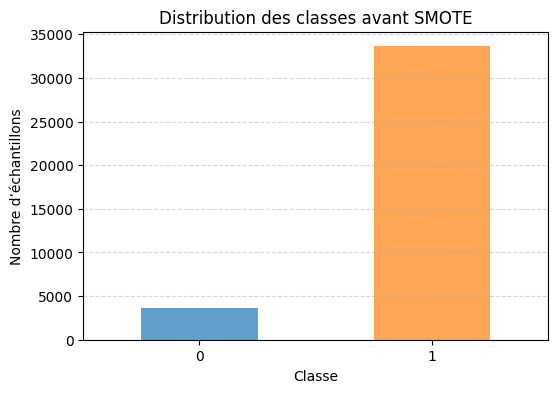

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
y_train.value_counts().sort_index().plot(
    kind='bar', color=['tab:blue', 'tab:orange'], alpha=0.7
)
plt.title("Distribution des classes avant SMOTE")
plt.xlabel("Classe")
plt.ylabel("Nombre d’échantillons")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [16]:
from imblearn.over_sampling import SMOTE
# Nombre cible pour la classe minoritaire (1)
target_minority = 10000

# Déterminer le ratio à appliquer
counts = y_train.value_counts()
major_class = counts.idxmax()
count_majority = counts[major_class]
sampling_strategy = target_minority / count_majority


smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


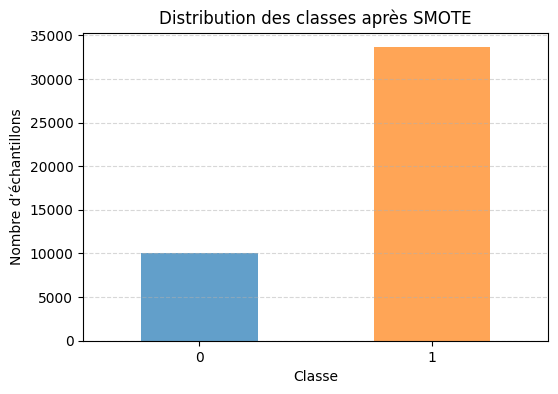

In [17]:
plt.figure(figsize=(6,4))
y_train_res.value_counts().sort_index().plot(
    kind='bar', color=['tab:blue', 'tab:orange'], alpha=0.7
)
plt.title("Distribution des classes après SMOTE")
plt.xlabel("Classe")
plt.ylabel("Nombre d’échantillons")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Function to print results
def print_results(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision (Class 0): {precision_score(y_true, y_pred, pos_label=0):.3f}")
    print(f"Recall (Class 0): {recall_score(y_true, y_pred, pos_label=0):.3f}")
    print(f"F1-Score (Class 0): {f1_score(y_true, y_pred, pos_label=0):.3f}")
    print(classification_report(y_true, y_pred))

In [20]:
# 1. Logistic Regression
print("\n1. Logistic Regression")
# Explanation: Linear model that predicts class probabilities using a logistic function, good for baseline with balanced class weights.
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print_results(y_test, y_pred_lr, "Logistic Regression")


1. Logistic Regression

Logistic Regression Results:
Accuracy: 0.877
Precision (Class 0): 0.439
Recall (Class 0): 0.933
F1-Score (Class 0): 0.597
              precision    recall  f1-score   support

           0       0.44      0.93      0.60       909
           1       0.99      0.87      0.93      8404

    accuracy                           0.88      9313
   macro avg       0.72      0.90      0.76      9313
weighted avg       0.94      0.88      0.90      9313



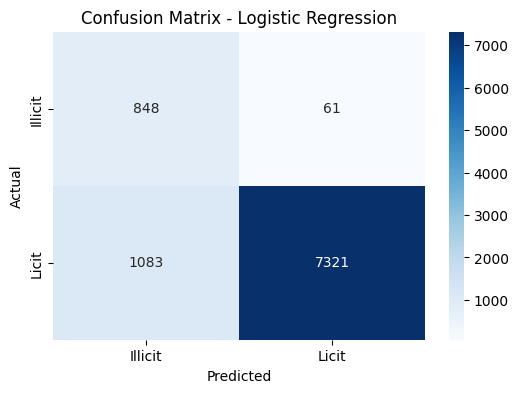

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Illicit', 'Licit'], yticklabels=['Illicit', 'Licit'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Example for Logistic Regression
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

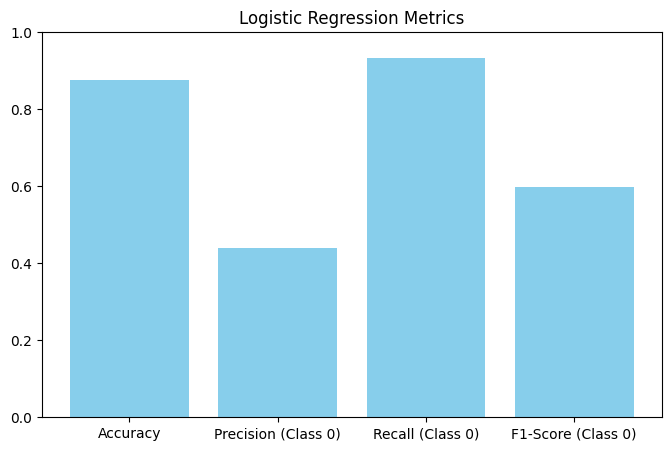

In [66]:
metrics = ['Accuracy', 'Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)']
values = [accuracy_score(y_test, y_pred_lr), precision_score(y_test, y_pred_lr, pos_label=0),
          recall_score(y_test, y_pred_lr, pos_label=0), f1_score(y_test, y_pred_lr, pos_label=0)]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='skyblue')
plt.title('Logistic Regression Metrics')
plt.ylim(0, 1)
plt.show()

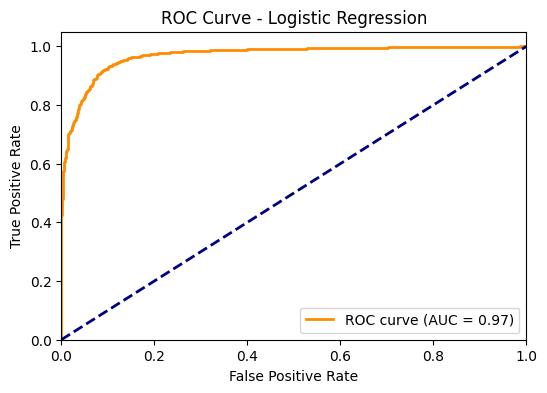

In [65]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Example for Logistic Regression (use predict_proba)
plot_roc_curve(y_test, lr.predict_proba(X_test), "Logistic Regression")

In [29]:
# 4. Random Forest
print("\n4. Random Forest")
# Explanation: Ensemble of trees averaging predictions, robust with feature importance.
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print_results(y_test, y_pred_rf, "Random Forest")


4. Random Forest

Random Forest Results:
Accuracy: 0.989
Precision (Class 0): 0.996
Recall (Class 0): 0.892
F1-Score (Class 0): 0.941
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       909
           1       0.99      1.00      0.99      8404

    accuracy                           0.99      9313
   macro avg       0.99      0.95      0.97      9313
weighted avg       0.99      0.99      0.99      9313



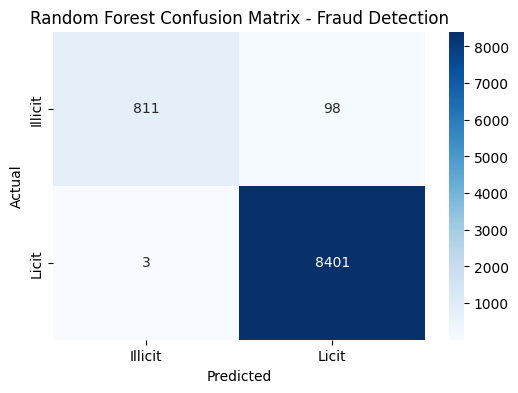

In [33]:
# 1. Classification Visualization: Confusion Matrix
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Illicit', 'Licit'], yticklabels=['Illicit', 'Licit'])
plt.title('Random Forest Confusion Matrix - Fraud Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

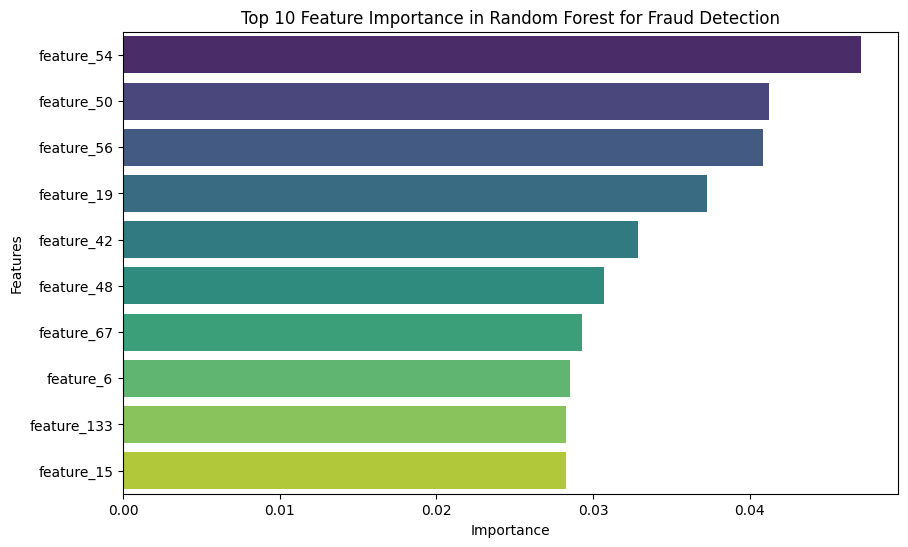

In [34]:
# 2. Feature Importance Visualization: Top 10 Features
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Top 10 Feature Importance in Random Forest for Fraud Detection')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

<Figure size 800x600 with 0 Axes>

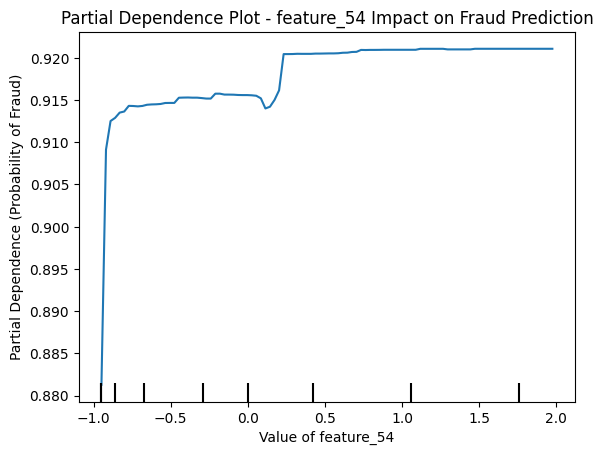

In [35]:
# 3. Feature Impact Visualization: Partial Dependence Plot for Top Feature
top_feature = feature_importance.iloc[0]['feature']
plt.figure(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(rf, X_test, features=[top_feature], feature_names=X.columns)
plt.title(f'Partial Dependence Plot - {top_feature} Impact on Fraud Prediction')
plt.xlabel(f'Value of {top_feature}')
plt.ylabel('Partial Dependence (Probability of Fraud)')
plt.show()

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [23]:
print("\n7. XGBoost")
# Explanation: Sequential tree boosting, excels with imbalanced tabular data.
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train == 1]) / len(y_train[y_train == 0]), random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print_results(y_test, y_pred_xgb, "XGBoost")


7. XGBoost

XGBoost Results:
Accuracy: 0.991
Precision (Class 0): 0.995
Recall (Class 0): 0.912
F1-Score (Class 0): 0.952
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       909
           1       0.99      1.00      1.00      8404

    accuracy                           0.99      9313
   macro avg       0.99      0.96      0.97      9313
weighted avg       0.99      0.99      0.99      9313



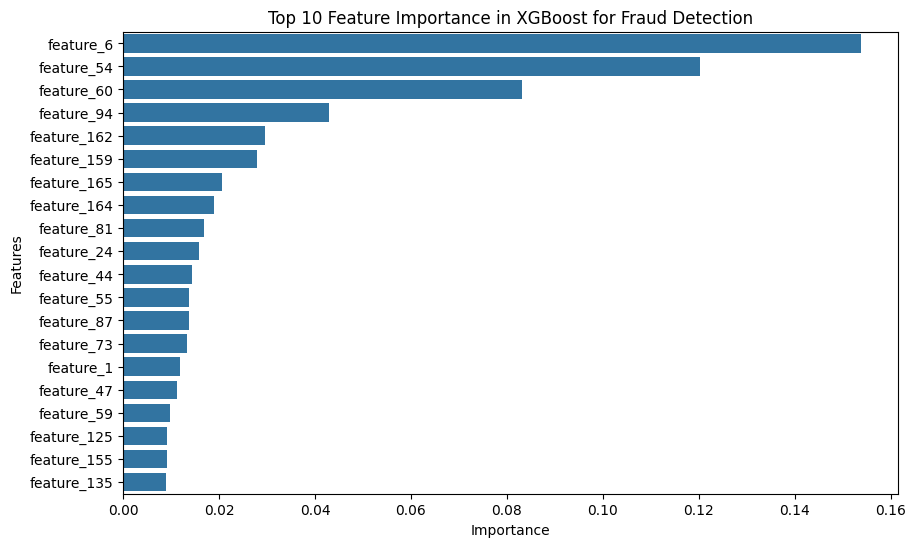

In [26]:
# Feature Importance Visualization
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': xgb.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))  # Top 10 features
plt.title('Top 10 Feature Importance in XGBoost for Fraud Detection')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

* Ces features sont les principaux indicateurs de fraude. 'feature_6' étant le plus influent, il pourrait représenter un pattern clé


XGBoost with Adjusted Threshold (0.8):
Accuracy: 0.010
Precision (Class 0): 0.011
Recall (Class 0): 0.103
F1-Score (Class 0): 0.020


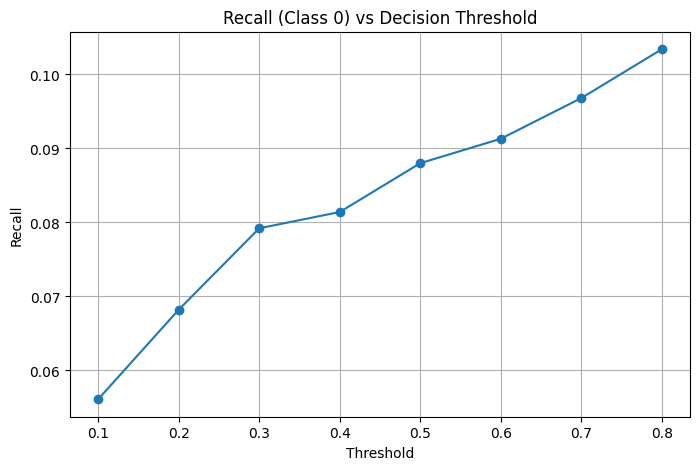

In [28]:
# Obtenir les probabilités prédites
y_pred_proba = xgb.predict_proba(X_test)[:, 0]  # Probabilité de classe 0 (illicite)

# Tester différents seuils
thresholds = np.arange(0.1, 0.9, 0.1)
recalls = []
for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    recalls.append(recall_score(y_test, y_pred_adjusted, pos_label=0))

# Trouver le meilleur seuil pour maximiser le recall
best_threshold = thresholds[np.argmax(recalls)]
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Afficher les résultats avec le meilleur seuil
print(f"\nXGBoost with Adjusted Threshold ({best_threshold:.1f}):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")
print(f"Precision (Class 0): {precision_score(y_test, y_pred_best, pos_label=0):.3f}")
print(f"Recall (Class 0): {recall_score(y_test, y_pred_best, pos_label=0):.3f}")
print(f"F1-Score (Class 0): {f1_score(y_test, y_pred_best, pos_label=0):.3f}")

# Visualisation du recall par seuil
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, marker='o')
plt.title('Recall (Class 0) vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

In [58]:
# 2. K-Nearest Neighbors
print("\n2. K-Nearest Neighbors")
# Explanation: Classifies based on k nearest neighbors, depends on standardized distances.
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print_results(y_test, y_pred_knn, "K-Nearest Neighbors")


2. K-Nearest Neighbors

K-Nearest Neighbors Results:
Accuracy: 0.972
Precision (Class 0): 0.865
Recall (Class 0): 0.843
F1-Score (Class 0): 0.853
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       909
           1       0.98      0.99      0.98      8404

    accuracy                           0.97      9313
   macro avg       0.92      0.91      0.92      9313
weighted avg       0.97      0.97      0.97      9313



In [59]:
# 3. Decision Tree
print("\n3. Decision Tree")
# Explanation: Splits data into branches based on features, interpretable but may overfit.
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print_results(y_test, y_pred_dt, "Decision Tree")


3. Decision Tree

Decision Tree Results:
Accuracy: 0.981
Precision (Class 0): 0.887
Recall (Class 0): 0.917
F1-Score (Class 0): 0.902
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       909
           1       0.99      0.99      0.99      8404

    accuracy                           0.98      9313
   macro avg       0.94      0.95      0.95      9313
weighted avg       0.98      0.98      0.98      9313



In [61]:
# 5. ExtraTreesClassifier
print("\n5. ExtraTreesClassifier")
# Explanation: Random split-based tree ensemble, faster and often effective.
et = ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
et.fit(X_train, y_train)
y_pred_et = et.predict(X_test)
print_results(y_test, y_pred_et, "ExtraTreesClassifier")


5. ExtraTreesClassifier

ExtraTreesClassifier Results:
Accuracy: 0.988
Precision (Class 0): 0.996
Recall (Class 0): 0.879
F1-Score (Class 0): 0.934
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       909
           1       0.99      1.00      0.99      8404

    accuracy                           0.99      9313
   macro avg       0.99      0.94      0.96      9313
weighted avg       0.99      0.99      0.99      9313

